# $X_{hh}$ accuracy

Patrick found a **5%** improvement for the SM by splitting into an inner and outer region. For their analysis, they deemed this split wasn't necessary / useful, but since % level differences *are* making a difference for the # of $\Delta \eta_{hh}$ bins that we'll choose at the end of the day, I think it makes sense to re-check this cut in tandem with the $\Delta \eta_{hh}$ bin choice :) 

This notebook is just meant to look into the justification for the *signal* for the correct and incorrect pairs.

In [12]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import json
from itertools import product
from glob import glob
import uproot

from statsmodels.stats.weightstats import DescrStatsW

import matplotlib.pyplot as plt
from matplotlib import gridspec

import os

os.sys.path+= ['../RRevolution/code/','../code/','../PAG-opt/']
from utils import mcToYr
from analysis import getXhh, getRegions
from triggerBuckets import trigger_lut
from processMNTs import get_xsec

from eventDisplays import rainbow_text

from plots import draw_SR, draw_VR, draw_CR

import logging
for name in logging.Logger.manager.loggerDict.keys():
    logging.getLogger(name).setLevel(logging.CRITICAL)

# Let's do ATLAS style plots too!
import matplotlib as mpl
os.sys.path.append( "../PyATLASstyle/")
import PyATLASstyle as pas
pas.applyATLASstyle(mpl)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


../PyATLASstyle/PyATLASstyle.py:12: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  font_list = font_manager.createFontList(font_files)


In [2]:
sort = 'Db_sort'
prodTag='JUN20'
pairing='min_dR1'

In [3]:
mc16a = pd.read_parquet(f'../data/SMNR_mc16a-{prodTag}/df_{pairing}_{sort}_VEC.parquet') 
mc16d = pd.read_parquet(f'../data/SMNR_mc16d-{prodTag}/df_{pairing}_{sort}_VEC.parquet')
mc16e = pd.read_parquet(f'../data/SMNR_mc16e-{prodTag}/df_{pairing}_{sort}_VEC.parquet')

In [4]:
k10a = pd.read_parquet(f'../data/k10_mc16a-{prodTag}/df_{pairing}_{sort}_VEC.parquet') 
k10d = pd.read_parquet(f'../data/k10_mc16d-{prodTag}/df_{pairing}_{sort}_VEC.parquet')
k10e = pd.read_parquet(f'../data/k10_mc16e-{prodTag}/df_{pairing}_{sort}_VEC.parquet')

In [5]:
x1,y1 = 124, 117

In [6]:
for df,yr in zip([mc16a,mc16d,mc16e,k10a,k10d,k10e],[16,17,18]*2):
    
    df['minQ'] = np.min(df[[f'Db_h{i}_j{j}' for i,j in product([1,2],[1,2])]],axis=1)
    
    df[f'Xhh_{x1}_{y1}'] = getXhh(*df[['m_h1','m_h2']].values.T,x1,y1)
    df['correct'] = (df.correctPair == df.chosenPair)
    
    tDict = trigger_lut(yr)
    
    df['nr_bucket'] = 0
    df.loc[(df.lead_pt>170)& (df[tDict['2b1j']]),'nr_bucket'] = 1
    df.loc[(df.lead_pt<170)& (df[tDict['2b2j']]),'nr_bucket'] = 2
    
    df['m_4b'] = (df.abs_deta_hh < 1.5) & (df.ntag >= 4) & (df.X_wt > 1.5) & (df.nr_bucket != 0)
    

In [13]:
?getRegions

In [14]:
getRegions(df,x1,y1,kr='kr_124_117')

In [10]:
df=mc16e

df.loc[df['m_4b']&df.correct& (df.Xhh_124_117 > 1.6),'mc_sf'].sum()/df.loc[df['m_4b']& (df.Xhh_124_117 > 1.6),'mc_sf'].sum()

0.5663951501032555

In [15]:
df.loc[df['m_4b']&df.correct& (df.kr_124_117 ==1),'mc_sf'].sum()/df.loc[df['m_4b']& (df.kr_124_117 ==1),'mc_sf'].sum()

0.8702900661609932

In [16]:
df.loc[df['m_4b']&df.correct& (df.kr_124_117 ==2),'mc_sf'].sum()/df.loc[df['m_4b']& (df.kr_124_117 ==2),'mc_sf'].sum()

0.6933420045499816

In [7]:
te = "$\mathbf{ATLAS}$ Simulation Internal\n"
te += f"mc16e, {prodTag} MNT, 4b b-tag sort, "+"$\Delta \eta_{hh}$ inc\n"
te += "X_wt > 1.5, NR buckets, no VBF veto"

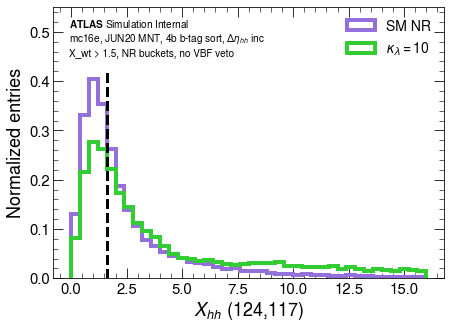

In [8]:
plt.figure(figsize=(7,5))

plt.hist(mc16e.loc[mc16e.m_4b,'Xhh_124_117'],40,(0,16),histtype='step',lw=4,
         weights=mc16e.loc[mc16e.m_4b,'mc_sf'],color='mediumpurple',density=True,
         label='SM NR')

plt.hist(k10e.loc[k10e.m_4b,'Xhh_124_117'],40,(0,16),histtype='step',lw=4,
         weights=k10e.loc[k10e.m_4b,'mc_sf'],color='limegreen',density=True,
         label='$\kappa_\lambda = 10$')

plt.plot()
plt.xlabel('$X_{hh}$ (124,117)',fontsize=18)
plt.ylabel('Normalized entries',fontsize=18)
plt.legend()

_,ymax = plt.ylim()
ylim = [0,1.3*ymax]
plt.plot([1.6]*2 , [0,ymax], 'k--')
plt.ylim(ylim)

#plt.title('4b, priv fw',loc='right',fontsize=15)

ax = plt.gca()
plt.text(0.04,0.96,te,ha='left',va='top',fontsize=10,transform=ax.transAxes)

plt.show()

In [9]:
n = get_xsec(1) / get_xsec(10)

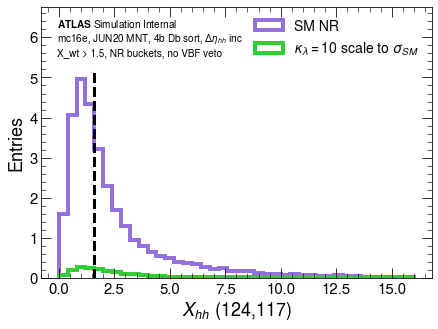

In [146]:
plt.figure(figsize=(7,5))

plt.hist(mc16e.loc[mc16e.m_4b,'Xhh_124_117'],40,(0,16),histtype='step',lw=4,
         weights=mc16e.loc[mc16e.m_4b,'mc_sf'],color='mediumpurple',
         label='SM NR')

plt.hist(k10e.loc[k10e.m_4b,'Xhh_124_117'],40,(0,16),histtype='step',lw=4,
         weights=n*k10e.loc[k10e.m_4b,'mc_sf'],color='limegreen',density=True,
         label='$\kappa_\lambda = 10$ scale to $\sigma_{SM}$')

plt.plot()
plt.xlabel('$X_{hh}$ (124,117)',fontsize=18)
plt.ylabel('Entries',fontsize=18)
plt.legend()

_,ymax = plt.ylim()
ylim = [0,1.3*ymax]
plt.plot([1.6]*2 , [0,ymax], 'k--')
plt.ylim(ylim)

#plt.title('4b, priv fw',loc='right',fontsize=15)

ax = plt.gca()
plt.text(0.04,0.96,te,ha='left',va='top',fontsize=10,transform=ax.transAxes)

plt.show()

Hmmmmmmm, maybe $\sigma$ is not really the right thing to scale this to, since this is actually a complicated function of acceptance x eff which varies as a function of $m_{hh}$?

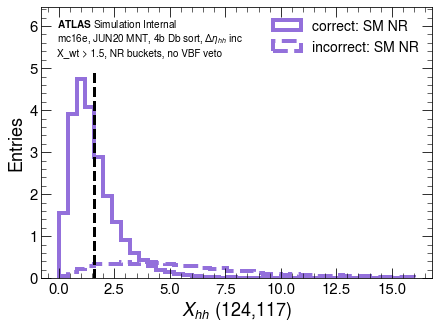

In [147]:
plt.figure(figsize=(7,5))

plt.hist(mc16e.loc[mc16e.m_4b & (mc16e.correctPair==mc16e.chosenPair),'Xhh_124_117'],
         40,(0,16),histtype='step',lw=4,
         weights=mc16e.loc[mc16e.m_4b & (mc16e.correctPair==mc16e.chosenPair),'mc_sf'],
         color='mediumpurple', label='correct: SM NR')

plt.hist(mc16e.loc[mc16e.m_4b & (mc16e.correctPair!=mc16e.chosenPair),'Xhh_124_117'],
         40,(0,16),histtype='step',lw=4,ls='--',
         weights=mc16e.loc[mc16e.m_4b & (mc16e.correctPair!=mc16e.chosenPair),'mc_sf'],
         color='mediumpurple', label='incorrect: SM NR')

plt.plot()
plt.xlabel('$X_{hh}$ (124,117)',fontsize=18)
plt.ylabel('Entries',fontsize=18)
plt.legend()

_,ymax = plt.ylim()
ylim = [0,1.3*ymax]
plt.plot([1.6]*2 , [0,ymax], 'k--')
plt.ylim(ylim)

#plt.title('4b, priv fw',loc='right',fontsize=15)

ax = plt.gca()
plt.text(0.04,0.96,te,ha='left',va='top',fontsize=10,transform=ax.transAxes)

plt.show()

By eye, I would like to put this cut at 2.6 or 2.7.

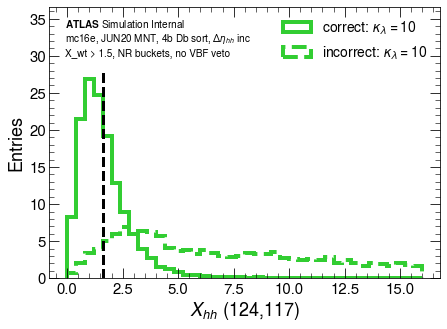

In [148]:
plt.figure(figsize=(7,5))

plt.hist(k10e.loc[k10e.m_4b & k10e.correct,'Xhh_124_117'],
         40,(0,16),histtype='step',lw=4,
         weights=k10e.loc[k10e.m_4b & k10e.correct,'mc_sf'],
         color='limegreen',#density=True,
         label='correct: $\kappa_\lambda = 10$')

plt.hist(k10e.loc[k10e.m_4b & ~k10e.correct,'Xhh_124_117'],
         40,(0,16),histtype='step',lw=4,ls='--',
         weights=k10e.loc[k10e.m_4b & ~k10e.correct,'mc_sf'],
         color='limegreen',#density=True,
         label='incorrect: $\kappa_\lambda = 10$')

plt.plot()
plt.xlabel('$X_{hh}$ (124,117)',fontsize=18)
plt.ylabel('Entries',fontsize=18)
plt.legend()

_,ymax = plt.ylim()
ylim = [0,1.3*ymax]
plt.plot([1.6]*2 , [0,ymax], 'k--')
plt.ylim(ylim)

#plt.title('4b, priv fw',loc='right',fontsize=15)

ax = plt.gca()
plt.text(0.04,0.96,te,ha='left',va='top',fontsize=10,transform=ax.transAxes)

plt.show()

**Plan:** Overlay SM w/ non-SM, but normalize the $\kappa_\lambda = 10$ sample to the appropriate cross-section.

In [149]:
get_xsec(1)

31.035800000000002

In [150]:
get_xsec(10)

672.2264

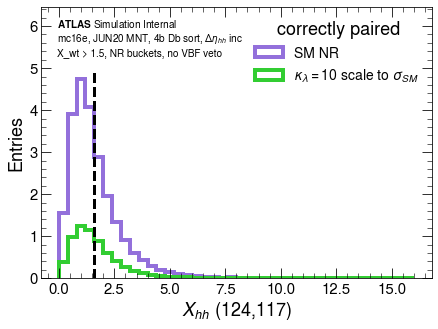

In [151]:
plt.figure(figsize=(7,5))


plt.hist(mc16e.loc[mc16e.m_4b & (mc16e.correctPair==mc16e.chosenPair),'Xhh_124_117'],
         40,(0,16),histtype='step',lw=4,
         weights=mc16e.loc[mc16e.m_4b & (mc16e.correctPair==mc16e.chosenPair),'mc_sf'],
         color='mediumpurple',#density=True,
         label='SM NR')

plt.hist(k10e.loc[k10e.m_4b & (k10e.correctPair==k10e.chosenPair),'Xhh_124_117'],
         40,(0,16),histtype='step',lw=4,
         weights=get_xsec(1)/get_xsec(10) * k10e.loc[k10e.m_4b & (k10e.correctPair==k10e.chosenPair),'mc_sf'],
         color='limegreen',#density=True,
         label=r'$\kappa_\lambda = 10$ scale to $\sigma_{SM}$')#'$\times \ \frac{\sigma_{SM} }{ \sigma (\kappa_\lambda = 10)}$ '
        
plt.plot()
plt.xlabel('$X_{hh}$ (124,117)',fontsize=18)
plt.ylabel('Entries',fontsize=18)
plt.legend(loc='upper right',bbox_to_anchor=(1,.9))

_,ymax = plt.ylim()
ylim = [0,1.3*ymax]
plt.plot([1.6]*2 , [0,ymax], 'k--')
plt.ylim(ylim)

    
ax = plt.gca()
plt.text(0.04,0.96,te,ha='left',va='top',fontsize=10,transform=ax.transAxes)

plt.text(.92,.95,'correctly paired',ha='right',va='top',transform=ax.transAxes,fontsize=18)
    

plt.show()

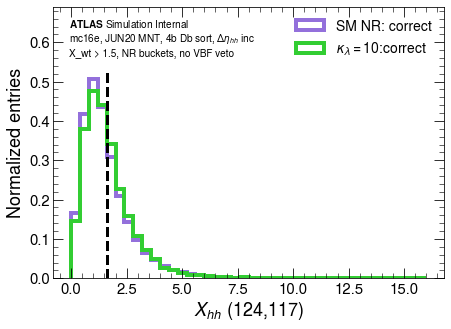

In [152]:
plt.figure(figsize=(7,5))


plt.hist(mc16e.loc[mc16e.m_4b & (mc16e.correctPair==mc16e.chosenPair),'Xhh_124_117'],
         40,(0,16),histtype='step',lw=4,
         weights=mc16e.loc[mc16e.m_4b & (mc16e.correctPair==mc16e.chosenPair),'mc_sf'],
         color='mediumpurple',density=True,
         label='SM NR: correct')

plt.hist(k10e.loc[k10e.m_4b & (k10e.correctPair==k10e.chosenPair),'Xhh_124_117'],
         40,(0,16),histtype='step',lw=4,
         weights=k10e.loc[k10e.m_4b & (k10e.correctPair==k10e.chosenPair),'mc_sf'],
         color='limegreen',density=True,
         label=r'$\kappa_\lambda = 10$:correct')
        
plt.plot()
plt.xlabel('$X_{hh}$ (124,117)',fontsize=18)
plt.ylabel('Normalized entries',fontsize=18)
plt.legend()#loc='upper right',bbox_to_anchor=(1,.9))

_,ymax = plt.ylim()
ylim = [0,1.3*ymax]
plt.plot([1.6]*2 , [0,ymax], 'k--')
plt.ylim(ylim)

    
ax = plt.gca()
plt.text(0.04,0.96,te,ha='left',va='top',fontsize=10,transform=ax.transAxes)

#plt.text(.92,.95,'correctly paired',ha='right',va='top',transform=ax.transAxes,fontsize=18)
    

plt.show()

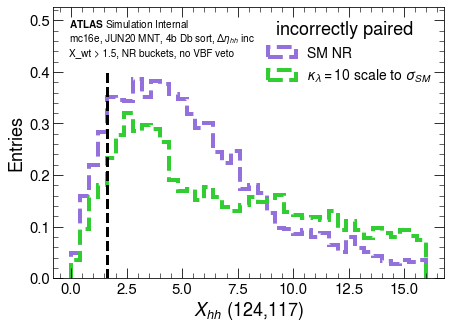

In [153]:
plt.figure(figsize=(7,5))


plt.hist(mc16e.loc[mc16e.m_4b & (mc16e.correctPair!=mc16e.chosenPair),'Xhh_124_117'],
         40,(0,16),histtype='step',lw=4,
         weights=mc16e.loc[mc16e.m_4b & (mc16e.correctPair!=mc16e.chosenPair),'mc_sf'],
         color='mediumpurple',ls='--',
         label='SM NR')

plt.hist(k10e.loc[k10e.m_4b & (k10e.correctPair!=k10e.chosenPair),'Xhh_124_117'],
         40,(0,16),histtype='step',lw=4,
         weights=get_xsec(1)/get_xsec(10) * k10e.loc[k10e.m_4b & (k10e.correctPair!=k10e.chosenPair),'mc_sf'],
         color='limegreen',ls='--',
         label=r'$\kappa_\lambda = 10$ scale to $\sigma_{SM}$')

plt.plot()
plt.xlabel('$X_{hh}$ (124,117)',fontsize=18)
plt.ylabel('Entries',fontsize=18)
plt.legend(loc='upper right',bbox_to_anchor=(1,.9))

_,ymax = plt.ylim()
ylim = [0,1.3*ymax]
plt.plot([1.6]*2 , [0,ymax], 'k--')
plt.ylim(ylim)

    
ax = plt.gca()
plt.text(0.04,0.96,te,ha='left',va='top',fontsize=10,transform=ax.transAxes)

plt.text(.92,.95,'incorrectly paired',ha='right',va='top',transform=ax.transAxes,fontsize=18)
    

plt.show()

**Where would we want to put the cuts if we wanted = yields in the Xhh SR for correctly paired signal?**

In [154]:
edg2 = np.linspace(0,1.5,3)
col2 = [f'({emin},{emax})' for emin,emax in zip(edg2[:-1],edg2[1:])]
med_2bins = pd.DataFrame(0,Xhhs,col2)

edg3 = np.linspace(0,1.5,4)
col3 = [f'({emin},{emax})' for emin,emax in zip(edg3[:-1],edg3[1:])]
med_3bins = pd.DataFrame(0,Xhhs,col3)


edg6 = np.linspace(0,1.5,7)
col6 = [f'({emin},{emax})' for emin,emax in zip(edg6[:-1],edg6[1:])]
med_6bins = pd.DataFrame(0,Xhhs,col6)


**Also j check the 3 SR boundary proposal w/ Xhh < 1.6**

In [12]:
Xhh = 1.6
  
for quant in [1/3,2/3]:
    
    mask = mc16e.m_4b & mc16e.correct  & (mc16e.Xhh_124_117 < Xhh)
    
    wstats = DescrStatsW(*mc16e.loc[mask,['Xhh_124_117','mc_sf']].values.T)
    cq = wstats.quantile(quant).values[0]

    mask = mc16e.m_4b  & (mc16e.Xhh_124_117 < Xhh)
    wstats = DescrStatsW(*mc16e.loc[mask, ['Xhh_124_117','mc_sf']].values.T)
    sq = wstats.quantile(quant).values[0]
    
    print(quant,cq,sq)
    

0.3333333333333333 0.737145637391131 0.7416000153458043
0.6666666666666666 1.1381612067422013 1.1450863146212815


In [185]:
Xhhs = np.linspace(0.1,8,80)

c_half = []
s_half = []

for Xhh in Xhhs:
    
    mask = mc16e.m_4b & mc16e.correct  & (mc16e.Xhh_124_117 < Xhh)
    
    wstats = DescrStatsW(*mc16e.loc[mask,['Xhh_124_117','mc_sf']].values.T)
    med = wstats.quantile(0.5).values[0]
    
    c_half.append(med)
    
    wstats = DescrStatsW(*mc16e.loc[mask, ['Xhh_124_117','mc_sf']].values.T)
    med = wstats.quantile(0.5).values[0]
    
    s_half.append(med)
    
    # 2 bins
    for emin, emax, c in zip(edg2[:-1],edg2[1:],col2):
    
        mi = mask & (mc16e.abs_deta_hh > emin) & (mc16e.abs_deta_hh < emax) 
        
        wstats = DescrStatsW(*mc16e.loc[mi, ['Xhh_124_117','mc_sf']].values.T)
        med = wstats.quantile(0.5).values[0]
        med_2bins.loc[Xhh,c] = med
        
    # 3 bins
    for emin, emax, c in zip(edg3[:-1],edg3[1:],col3):
    
        mi = mask & (mc16e.abs_deta_hh > emin) & (mc16e.abs_deta_hh < emax) 
        
        wstats = DescrStatsW(*mc16e.loc[mi, ['Xhh_124_117','mc_sf']].values.T)
        med = wstats.quantile(0.5).values[0]
        med_3bins.loc[Xhh,c] = med
        
    # 6 bins
    for emin, emax, c in zip(edg6[:-1],edg6[1:],col6):
    
        mi = mask & (mc16e.abs_deta_hh > emin) & (mc16e.abs_deta_hh < emax) 
        
        wstats = DescrStatsW(*mc16e.loc[mi, ['Xhh_124_117','mc_sf']].values.T)
        med = wstats.quantile(0.5).values[0]
        med_6bins.loc[Xhh,c] = med
    

In [158]:
from matplotlib.ticker import MultipleLocator

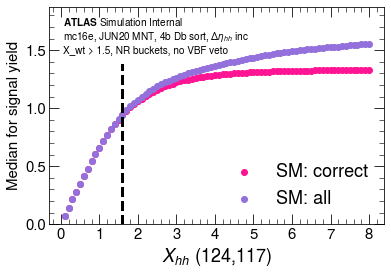

In [167]:
plt.scatter(Xhhs,c_half,color='deeppink',label='SM: correct')
plt.scatter(Xhhs,s_half,color='mediumpurple',label='SM: all')
plt.xlabel('$X_{hh}$ (124,117)', fontsize=18)
plt.ylabel('Median for signal yield')

_,ymax = plt.ylim()
plt.plot([1.6]*2,[0,0.85*ymax],'k--')
plt.ylim([0,1.15*ymax])

plt.legend(loc='lower right',fontsize=18)

ax = plt.gca()
plt.text(0.04,0.96,te,ha='left',va='top',fontsize=10,transform=ax.transAxes)

ax.xaxis.set_major_locator(MultipleLocator(1))

plt.show()


In [171]:
Xhhs[15],c_half[15]

(1.6, 0.9403692630230444)

In [168]:
Xhhs[15],s_half[15]

(1.6, 0.9462992868946506)

In [169]:
Xhhs[20],s_half[20]

(2.1, 1.1000594320519357)

In [170]:
Xhhs[21],s_half[21]

(2.2, 1.1219710348839318)

What is this saying?? 
1. For *correctly paired* events, the current cut keeps *less than 1/2* of our correctly paired signal.
2. It's also sort of a nice way to vis that 2.6 is getting us *closer* to the plateau.

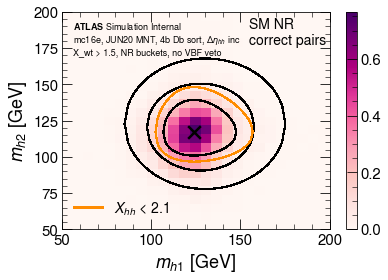

In [175]:
m = mc16e.m_4b & (mc16e.correctPair==mc16e.chosenPair)

n, ex, ey, _ = plt.hist2d( *mc16e.loc[m,['m_h1','m_h2']].values.T,
                           25,[(50,200),(50,200)],cmap='RdPu',
                           weights=mc16e.loc[m,'mc_sf'] )

plt.plot()
plt.xlabel('$m_{h1}$ [GeV]',fontsize=18)
plt.ylabel('$m_{h2}$ [GeV]',fontsize=18)
plt.colorbar()

ax = plt.gca()
plt.text(.7,.975,'SM NR\ncorrect pairs',transform=ax.transAxes,ha='left',va='top',fontsize=14)
plt.text(0.04,0.96,te,ha='left',va='top',fontsize=9,transform=ax.transAxes)

c='k'            
plt.scatter([x1],[y1],160,marker='x',color=c)
for f in [draw_SR,draw_VR,draw_CR]:
    x,y = f(x1,y1)
    plt.plot(x,y,c,lw=1.2)

    
Xhh_cut = 2.1
x,y = draw_SR(x1,y1,Xhh_cut)
plt.plot(x,y,'darkorange',lw=1.2,label='$X_{hh}$ < '+f'{Xhh_cut}')    
plt.legend(loc='lower left')

#plt.savefig(f'{figDir}/mp_4b_Xwt{ti}{rTag}.pdf', bbox_inches='tight')

plt.show()

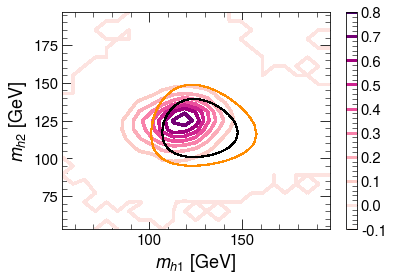

In [176]:
xx = 0.5 * (ex[1:] + ex[:-1])
yy = 0.5 * (ey[1:] + ey[:-1])

x,y = np.meshgrid(xx,yy)

plt.contour(x,y,n,cmap='RdPu')

plt.xlabel('$m_{h1}$ [GeV]',fontsize=18)
plt.ylabel('$m_{h2}$ [GeV]',fontsize=18)

x,y = draw_SR(x1,y1)
plt.plot(x,y,c,lw=1.2)

    
Xhh_cut = 2.2
x,y = draw_SR(123,116,Xhh_cut)
plt.plot(x,y,'darkorange',lw=1.2)

plt.colorbar()
plt.show()

Ok, what these contour curves are drawing are where the 2d histogram has a constant height, but I think what I'm actually more interested in is how to *enclose* the right amount of area as the signal.

**Question:** How much might we hope to gain by loosening this cut?

So, operating under an assumption rn that we're in a statistically limited regime, our limit should scale like $ S / \sqrt{B}$ 

In [177]:
S = np.sum(mc16e.loc[mc16e.m_4b,'mc_sf'])

s1p6 = np.sum(mc16e.loc[mc16e.m_4b & (mc16e.Xhh_124_117 < 1.6),'mc_sf'])

s2p0 = np.sum(mc16e.loc[mc16e.m_4b & (mc16e.Xhh_124_117 < 2.0),'mc_sf'])
s2p1 = np.sum(mc16e.loc[mc16e.m_4b & (mc16e.Xhh_124_117 < 2.1),'mc_sf'])
s2p2 = np.sum(mc16e.loc[mc16e.m_4b & (mc16e.Xhh_124_117 < 2.2),'mc_sf'])


In [178]:
S, s1p6, s2p2

(31.09989777703325, 14.96924110419179, 19.40945842444652)

In [179]:
s2p2 / s1p6

1.2966227405483735

In [180]:
np.sqrt(s2p2 / s1p6)

1.1386934357184877

In [181]:
np.sqrt(s2p1 / s1p6)

1.121408615422522

In [182]:
np.sqrt(s2p0 / s1p6)

1.1024920398887728

Optimistically, this could be a 12% increase for our limits as well!!! (Hopefully orthogonal to $\Delta \eta_{hh}$ as well, but I guess remains to be seen haha.

**To test something out, I think I should start by choosing the *largest* SR that doesn't go outside of the CR??**

In [183]:
Xhh_cut = 2.2
x,y = draw_SR(x1,y1,Xhh_cut)
np.sqrt((x - 1.03*x1)**2 + (y - 1.03*y1)**2)

array([26.31614677, 27.59270058, 27.95713471, 28.10220558, 28.1191847 ,
       28.05003859, 27.91949869, 27.74413877, 27.53600488, 27.30436706,
       27.05667281, 26.79911116, 26.53696691, 26.27485293, 26.01686702,
       25.76669962, 25.52770817, 25.30296782, 25.095305  , 24.90731818,
       24.74138907, 24.59968661, 24.48416579, 24.39656295, 24.33838914,
       24.31092264, 24.31520213, 24.3520212 , 24.42192507, 24.5252101 ,
       24.66192616, 24.83188197, 25.0346528 , 25.26959018, 25.53583236,
       25.83231451, 26.157777  , 26.51076992, 26.88965104, 27.29257387,
       27.71745996, 28.16194644, 28.62329243, 29.09821254, 29.58257039,
       30.07077295, 30.55442507, 31.01871335, 31.4285434 , 31.45083552,
       31.45083552, 30.2018518 , 29.4112975 , 28.74875358, 28.18150189,
       27.69675472, 27.28772982, 26.94997952, 26.68000141, 26.47460224,
       26.33057624, 26.2445389 , 26.21284819, 26.23157918, 26.2965329 ,
       26.40326645, 26.54713562, 26.72334302, 26.926987  , 27.15

In [184]:
Xhh_cut = 2.1
x,y = draw_SR(x1,y1,Xhh_cut)
np.sum(np.sqrt((x - 1.03*x1)**2 + (y - 1.03*y1)**2) > 30)

0

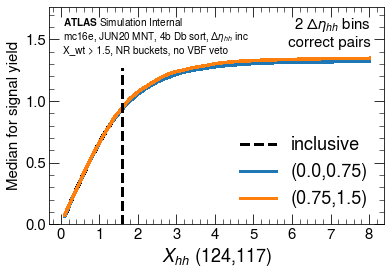

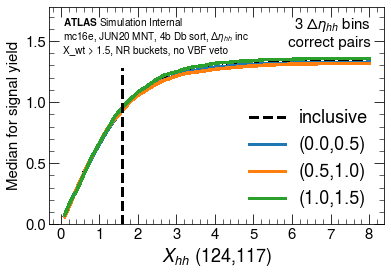

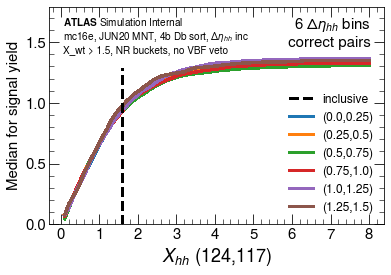

In [194]:
for nb,meds,cs in zip([2,3,6],[med_2bins,med_3bins,med_6bins],[col2,col3,col6]):

    plt.figure()
    plt.plot(Xhhs,c_half,'k--',label='inclusive')

    for c in cs:
        plt.plot(Xhhs,meds[c],label=c)

    #plt.scatter(Xhhs,s_half,color='mediumpurple',label='SM: all')
    plt.xlabel('$X_{hh}$ (124,117)', fontsize=18)
    plt.ylabel('Median for signal yield')

    _,ymax = plt.ylim()
    plt.plot([1.6]*2,[0,0.9*ymax],'k--')
    plt.ylim([0,1.25*ymax])

    plt.legend(loc='lower right',fontsize=12 if nb==6 else 18)

    ax = plt.gca()
    plt.text(0.04,0.96,te,ha='left',va='top',fontsize=10,transform=ax.transAxes)

    plt.text(0.96,0.96,str(nb)+' $\Delta \eta_{hh}$ bins\n correct pairs',
             ha='right',va='top',fontsize=15,transform=ax.transAxes)

    ax.xaxis.set_major_locator(MultipleLocator(1))

    plt.show()



In [198]:
med_2bins.loc[1.6]

(0.0,0.75)    0.935769
(0.75,1.5)    0.945247
Name: 1.6, dtype: float64

In [199]:
med_3bins.loc[1.6]

(0.0,0.5)    0.938783
(0.5,1.0)    0.931048
(1.0,1.5)    0.955288
Name: 1.6, dtype: float64

In [200]:
med_6bins.loc[1.6]

(0.0,0.25)    0.939696
(0.25,0.5)    0.936183
(0.5,0.75)    0.930456
(0.75,1.0)    0.932408
(1.0,1.25)    0.943331
(1.25,1.5)    0.973932
Name: 1.6, dtype: float64

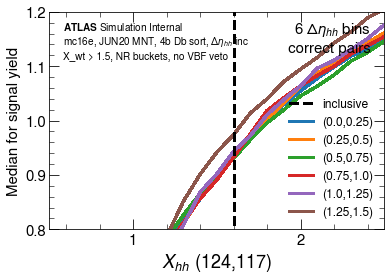

In [197]:
plt.figure()
plt.plot(Xhhs,c_half,'k--',label='inclusive')

for c in cs:
    plt.plot(Xhhs,meds[c],label=c)

#plt.scatter(Xhhs,s_half,color='mediumpurple',label='SM: all')
plt.xlabel('$X_{hh}$ (124,117)', fontsize=18)
plt.ylabel('Median for signal yield')

_,ymax = plt.ylim()
plt.plot([1.6]*2,[0,0.9*ymax],'k--')
plt.ylim([0.8,1.2])
plt.xlim([.5,2.5])
plt.legend(loc='lower right',fontsize=12 if nb==6 else 18)

ax = plt.gca()
plt.text(0.04,0.96,te,ha='left',va='top',fontsize=10,transform=ax.transAxes)

plt.text(0.96,0.96,str(nb)+' $\Delta \eta_{hh}$ bins\n correct pairs',
         ha='right',va='top',fontsize=15,transform=ax.transAxes)

ax.xaxis.set_major_locator(MultipleLocator(1))

plt.show()


Ok, so the very last bin (for example) would want the inner circle to be a little *larger* to maintain 50% signal efficiency, but by in large, these $\Delta \eta_{hh}$ bins seem to be showing similar $X_{hh}$ profiles (or at least, this is what this median tracking curve is showing).